<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw9/micro_factors_and_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW09 Pipeline

Factor: Sychology Utilities
* Sentiment
* Group confirmation

Reference: 
* https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c
* https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


## Data preparation
* Scrape data from politifact
* Fetch twitter tweets by APIs

**Scrape data from politifact**

In [1]:
!pip install -q beautifulsoup4
!pip install -q vaderSentiment

     |████████████████████████████████| 133kB 9.2MB/s 


In [2]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup  

In [3]:
#Get all issues

url = "https://www.politifact.com/issues/"
issues = []
r = requests.get(url)
soup = BeautifulSoup(r.text,'html.parser')
results = soup.find_all('div', attrs={'class':'c-chyron__value'})
for result in results:
  name = result.find('a').text
  issue = result.find('a')['href'].replace("/","")
  issues.append((name, issue))

In [4]:
url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

records = []  

for i in range(1,2):
  for issue, issue_url in issues[:5]:
    fUrl = url.format(pgno=str(i), category=issue_url)
    r = requests.get(fUrl)
    soup = BeautifulSoup(r.text, 'html.parser')  
    results = soup.find_all('article', attrs={'class':'m-statement'})
    for result in results:
      date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
      reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
      author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
      statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
      statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
      article_url =  result.find('a')['href']
      verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
      records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  
df_sample = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_sample.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
1,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
2,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
3,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/
4,"October 13, 2020",Abortion,Chris Nichols,Facebook posts,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false,/personalities/facebook-posts/


In [5]:
df_sample.isnull().sum()

Date           0
Issue          0
Reporter       0
Author         0
Statement      0
Description    0
Verdict        0
Url            0
dtype: int64

**Import Required Packages**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import requests
import string
from string import punctuation
from io import BytesIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


** Load twitter data set

In [7]:
train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-7fkaGbvXcppizTYkyM_weWptbtyab7PVUXJZdpJb7aJ-mKXtB1zTkY7DizLU7M64oYMoE8lPJQ1V/pub?output=csv'
r = requests.get(train_url)
data = r.content
df_tweet = pd.read_csv(BytesIO(data))
df_tweet.shape

(762, 3)

**Scrape twitter data language as english**

In [8]:
!pip install -q datasketch
!pip install -q networkx 

     |████████████████████████████████| 71kB 3.9MB/s 


In [9]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
import re
import time
from datasketch import MinHash, MinHashLSH

In [10]:
access_token = '1311987544507084800-iYuPqERzopIZuuyxaZ8xnqARcyKrR1'
access_token_secret = 'DCJg5kE7srBZRToNlzF0xqT3hcxonnXMlMXKWjX91wyTe'
consumer_key = 'YQLJJb0ELY5pdXbx7WkQXtRXo'
consumer_secret = 'HCgQga7Mj33C5E19IP7Dr3qGChmc85M6IEYXSGtI6g4cdplBYw'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweets = []

count = 1

"""if you don't add since= as one of the parameters, Twitter will sample the last 7 days worth of data depending
on how many total tweets there are with the specific hashtag, keyword, or key phrase that you are looking for. You can
manually add in the number of items (or tweets) you want to get back in the items() section."""

for tweet in tweepy.Cursor(api.search, q="#breaking", count=450, since='2020-04-10', lang='en').items(5000):
  count += 1
  try:
    data = [tweet.text, tweet.retweet_count]
    data = tuple(data)
    tweets.append(data)
  
  except tweepy.TweepError as e:
    print(e.reason)
    continue

  except StopIteration:
    break

df_train = pd.DataFrame(tweets, columns = ['Statement', 'NumOfRetweets'])
df_train = df_train[:1000]
df_train.head()

,Statement,NumOfRetweets
0,RT @TimesNow: #Breaking | West Bengal: Mamata ...,72
1,RT @rameshlaus: #BREAKING : #BCCI confirms all...,992
2,RT @BettyKPIX: #breaking shooting investigatio...,15
3,#BREAKING: One in hospital after report of peo...,0
4,#China builds base in #Djibouti to deploy airc...,0


**Plot the Rating visualization graph**

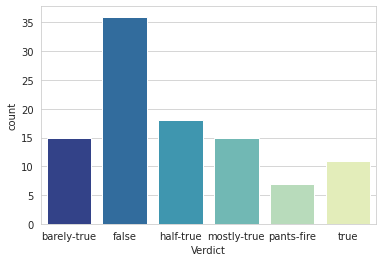

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Verdict',data=df_sample, palette='YlGnBu_r')

**Calculation of Polarity**

In [12]:
df_sample['VerdictRating'] = df_sample['Verdict'].apply(lambda x: 'Positive' if x in ['true', 'mostly-true', 'half-true'] else 'Negative')


## Microfactors generation

**1. Confirmation generation**

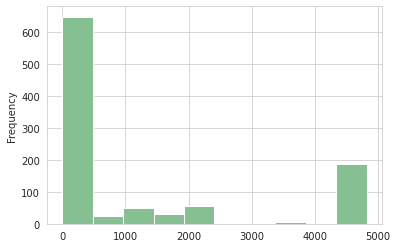

In [13]:
pd.options.mode.chained_assignment = None

ulimit = np.percentile(df_train.NumOfRetweets, 99)
df_train['NumOfRetweets'].loc[df_train['NumOfRetweets']>ulimit] = ulimit
llimit = np.percentile(df_train.NumOfRetweets.values, 1)
df_train['NumOfRetweets'].loc[df_train['NumOfRetweets']<llimit] = llimit
df_train['NumOfRetweets'].plot.hist(color='#86bf91')

In [14]:
df_train['ScaleConfirmation'] = df_train['NumOfRetweets']/df_train['NumOfRetweets'].mean()
df_train['ScaleConfirmation'] = df_train['ScaleConfirmation'].apply(lambda x: 1 if x > 1 else x)
df_train.head()

,Statement,NumOfRetweets,ScaleConfirmation
0,RT @TimesNow: #Breaking | West Bengal: Mamata ...,72.0,0.060143
1,RT @rameshlaus: #BREAKING : #BCCI confirms all...,992.0,0.828638
2,RT @BettyKPIX: #breaking shooting investigatio...,15.0,0.012530
3,#BREAKING: One in hospital after report of peo...,0.0,0.000000
4,#China builds base in #Djibouti to deploy airc...,0.0,0.000000


Where we can see very few of them have over than 2000 retweets.

The more retweets, the more social confirmation. We split the number of retwees to 'Confirmation' as 'positive' and 'negative', 300 is the threshold we can use for social media.

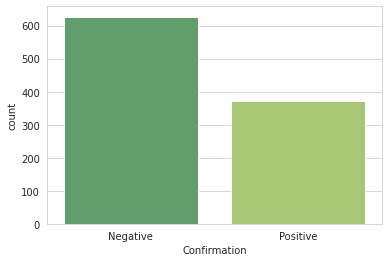

In [15]:
df_train['Confirmation'] = df_train['NumOfRetweets'].apply(lambda x: 'Positive' if x > 300 else 'Negative')
sns.set_style('whitegrid')
sns.countplot(x='Confirmation',data=df_train, palette='summer')

**Text Preprocessing**

In [16]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

**Apply the method "get_text_processing" into column statement text**

In [17]:
df_train['Statement'] = df_train['Statement'].apply(get_text_processing)
df_sample['Statement'] = df_sample['Statement'].apply(get_text_processing)


**2. Sentiment Generation**

In [18]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return abs(_sentiment)

**Apply the method "get_text_setiment" into column statement text**

In [19]:
df_train['ScaleSentiment'] = df_train['Statement'].apply(get_text_sentiment)
df_train['Sentiment'] = df_train['ScaleSentiment'].apply(lambda x: 'Positive' if float(x) > 0.5 else 'Negative')

**Visualize Sentiment Polarity**

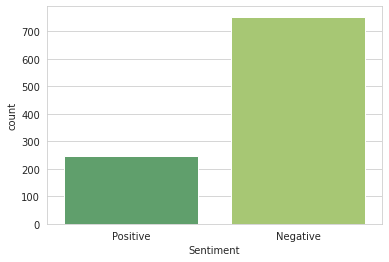

In [20]:
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=df_train, palette='summer')

## Factor generation
* Combine micro-factors to factor using polynomial

In [21]:
df = df_train.copy()
# Get factor from micro factors by polynomial
df['ScalePsychology'] = df['ScaleConfirmation'] * 0.6 + df['ScaleSentiment'] * 0.4
_mean = df['ScalePsychology'].mean()
df['PsychologyUtilites'] = df['ScalePsychology'].apply(lambda x: 'Positive' if x > 0.45 else 'Negative')
df.head()

,Statement,NumOfRetweets,ScaleConfirmation,Confirmation,ScaleSentiment,Sentiment,ScalePsychology,PsychologyUtilites
0,RT TimesNow Breaking West Bengal Mamata Banerj...,72.0,0.060143,Negative,0.6249,Positive,0.286046,Negative
1,RT rameshlaus BREAKING BCCI confirms IPL2021 p...,992.0,0.828638,Positive,0.5994,Positive,0.736943,Positive
2,RT BettyKPIX breaking shooting investigation G...,15.0,0.012530,Negative,0.2023,Negative,0.088438,Negative
3,BREAKING One hospital report people shooting a...,0.0,0.000000,Negative,0.0000,Negative,0.000000,Negative
4,China builds base Djibouti deploy aircraft car...,0.0,0.000000,Negative,0.0000,Negative,0.000000,Negative


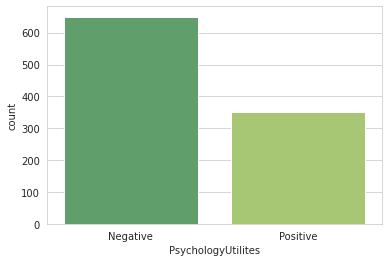

In [22]:
sns.set_style('whitegrid')
sns.countplot(x='PsychologyUtilites',data=df, palette='summer')

In [23]:
df.shape

(1000, 8)

##Define pipeline

Pipeline includes vectorization tfidf transformer and SVM training

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# A pipeline with data preprocessing, training and prediction
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(C=1)),
])

def data_to_pipeline(df, _source=None, _target=None):
  # Split data for training and validation
  X, y = df[_source].values, df[_target].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
  # Training and prediction
  pipeline.fit(X_train, y_train)
  scores = cross_val_score(pipeline, X_test, y_test, cv=3)
  print('using %s to predict %s' % (_source, _target))
  print('cross validation scores:', scores)
  print('prediction score:', pipeline.score(X_test, y_test))

def factors_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Sentiment')
  data_to_pipeline(df, _source='Statement', _target='Confirmation')
  data_to_pipeline(df, _source='Statement', _target='PsychologyUtilites')

## Apply pipeline on microfactors and factor

In [47]:
factors_pipeline(df)

using Statement to predict Sentiment
cross validation scores: [0.87 0.89 0.96]
prediction score: 0.9533333333333334
using Statement to predict Confirmation
cross validation scores: [0.99 0.97 0.94]
prediction score: 0.9966666666666667
using Statement to predict PsychologyUtilites
cross validation scores: [1.   0.97 0.99]
prediction score: 1.0


##Conclusion

1. Both sentiment and confirmation are predictable by the article content.
2. Stacking ensembling model performs better than single model.
3. CNN performs better than other models.
4. The factor PsychologyUtilites prediction is better using new twitter dataset 90% than previous dataset 70%.